In [40]:
export = False

In [41]:
# parse
import re
loss_regex = r"TrainLoss: (\d+\.\d+)"
tp_regex = r": (\d+\.\d) img\/sec"
comp_regex = r"Bandwidth savings: from \d+ to \d+ \((\d+\.\d+)x\)"
gpu_regex = r"Number of GPUs: (\d)"

def parse(file, regex):
    nums = []
    for line in open(file, "r").readlines():
        matches = re.search(regex, line)
        if matches:
            nums.append(float(matches.group(1)))
    return nums

def parse_loss(file):
    return parse(file, loss_regex)

def parse_tp(file):
    return parse(file, tp_regex)

def parse_comp_ratio(file):
    return parse(file, comp_regex)

def parse_num_gpu(file):
    return parse(file, gpu_regex)

In [42]:
from os import listdir
import pandas as pd

data = {
    "loss": [],
    "tp": [],
    "name": [],
    "gpu": []
}

for name in listdir("benchmarks"):
    file = f"benchmarks/{name}"
    attrs = {}
    data["loss"].append(parse_loss(file))
    data["tp"].append(parse_tp(file))
    
    comp = parse_comp_ratio(file)
    if len(comp) > 0:
        name += f" (compression: {comp[0]:,.0f}x)"
    
    data["name"].append(name)

    gpu = parse_num_gpu(file)
    if len(gpu) > 0:
        data["gpu"].append(gpu[0])
    else:
        data["gpu"].append(None)
    

df = pd.DataFrame(data)
df

,loss,tp,name,gpu
0,"[6.914067, 3.598126, 2.977381, 2.348433, 2.180...","[90.7, 90.3, 90.2, 89.8, 89.6, 89.2, 88.8, 88....",qadam,1.0
1,"[6.914067, 8.547184, 4.836272, 3.688952, 2.924...","[43.2, 43.0, 42.9, 42.6, 42.4, 42.1, 42.1, 41....","sketch (compression: 25,557x)",1.0


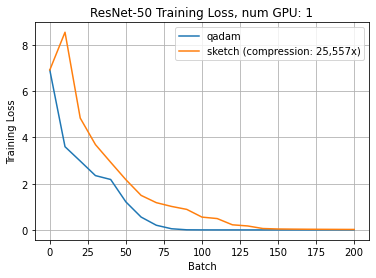

In [43]:
import numpy as np
import matplotlib.pyplot as plt


gpus = df["gpu"].unique()
gpus.sort()
for num_gpu in gpus:
    num_iters = None
    
    for i, row in df[df["gpu"]==num_gpu].iterrows():
        row_iters = len(row["loss"])
        if num_iters is None: num_iters = row_iters
        else: assert row_iters == num_iters, "number of its should be consistent"
        t = np.arange(0, num_iters*10, 10)
        plt.plot(t, row["loss"], label=row["name"])
    
    plt.title(f"ResNet-50 Training Loss, num GPU: {num_gpu:.0f}")
    plt.xlabel("Batch")
    plt.ylabel("Training Loss")
    plt.grid(True)
    plt.legend()
    if export: plt.savefig(f"{num_gpu:.0f}-loss.svg")
    plt.show()

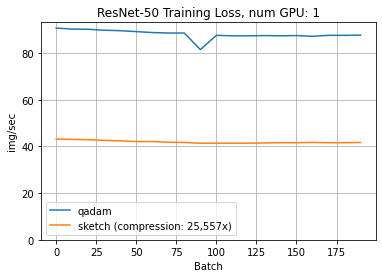

In [44]:
t = np.arange(10, 110, 10)

import numpy as np
import matplotlib.pyplot as plt

gpus = df["gpu"].unique()
gpus.sort()
for num_gpu in gpus:
    num_iters = None
    
    for i, row in df[df["gpu"]==num_gpu].iterrows():
        row_iters = len(row["tp"])
        if num_iters is None: num_iters = row_iters
        else: assert row_iters == num_iters, "number of its should be consistent"
        t = np.arange(0, num_iters*10, 10)
        plt.plot(t, row["tp"], label=row["name"])

    plt.title(f"ResNet-50 Training Loss, num GPU: {num_gpu:.0f}")
    plt.xlabel("Batch")
    plt.ylabel("img/sec")
    plt.grid(True)
    plt.legend()
    plt.ylim(bottom=0)
    if export: plt.savefig(f"{num_gpu:.0f}-tp.svg")
    plt.show()